In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
dataset_dir = "dataset/04015/"
os.listdir(dataset_dir)

['annotation.txt', 'DATA.csv']

- Read Annotation file

In [3]:
file = open(dataset_dir + 'annotation.txt',"r") 
annotations = file.readlines()
file.close()

In [4]:
annotations

['      Time     Sample #  Type  Sub Chan  Num\tAux\n',
 '[09:00:00.120]       30     +    0    0    0\t(N\n',
 '[09:06:50.336]   102584     +    0    0    0\t(AFIB\n',
 '[09:07:58.416]   119604     +    0    0    0\t(N\n',
 '[09:08:07.092]   121773     +    0    0    0\t(AFIB\n',
 '[09:08:08.776]   122194     +    0    0    0\t(N\n',
 '[09:08:53.392]   133348     +    0    0    0\t(AFIB\n',
 '[09:11:07.428]   166857     +    0    0    0\t(N\n',
 '[10:13:04.980]  1096245     +    0    0    0\t(AFIB\n',
 '[10:13:12.216]  1098054     +    0    0    0\t(N\n',
 '[10:15:41.184]  1135296     +    0    0    0\t(AFIB\n',
 '[10:15:58.380]  1139595     +    0    0    0\t(N\n',
 '[10:34:49.744]  1422436     +    0    0    0\t(AFIB\n',
 '[10:34:54.192]  1423548     +    0    0    0\t(N\n',
 '[10:37:17.108]  1459277     +    0    0    0\t(AFIB\n',
 '[10:37:21.664]  1460416     +    0    0    0\t(N\n']

In [5]:
label_idx = []
for item in annotations[1:8] :
    item_split = item.split()
    label_idx.append([item_split[0].replace("[", "").replace("]", ""), item_split[-1].replace("(", "")])

In [7]:
label_idx

[['09:00:00.120', 'N'],
 ['09:06:50.336', 'AFIB'],
 ['09:07:58.416', 'N'],
 ['09:08:07.092', 'AFIB'],
 ['09:08:08.776', 'N'],
 ['09:08:53.392', 'AFIB'],
 ['09:11:07.428', 'N']]

- Read & formatting ECG data

In [8]:
df_04015 = pd.read_csv(dataset_dir + "DATA.csv", sep=",")

df_04015 = df_04015.drop(0) 
df_04015.columns = ['Time', 'ECG']

df_04015['ECG'] = df_04015['ECG'].str.replace(';;', '')
df_04015['ECG'] = pd.to_numeric(df_04015['ECG'])

# peak reduction
df_04015[df_04015['ECG'] > 2] = 2
df_04015[df_04015['ECG'] < -2] = -2

df_04015["Time"] = df_04015['Time'].str.replace("[", "")
df_04015["Time"] = df_04015['Time'].str.replace("]", "")
df_04015["Time"] = df_04015['Time'].str.replace("'", "")

df_04015["Time"] = pd.to_datetime(df_04015["Time"], errors='coerce')

df_04015.set_index("Time", inplace=True)

In [9]:
df_04015.head()

,ECG
Time,
2020-12-03 09:00:00.000,-0.275
2020-12-03 09:00:00.004,-0.295
2020-12-03 09:00:00.008,-0.310
2020-12-03 09:00:00.012,-0.315
2020-12-03 09:00:00.016,-0.300


- plot signal 

In [10]:
def plot_signal(data, fs, label="ECG sample raw data"):
    data = data.values[:,0]
    plt.figure(figsize=(20, 5))
    plt.ylabel("Amplitude")

    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.plot(times, data)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    plt.ylim([-2.1, 2.1])
    plt.title(label)
    plt.grid(True)
    plt.show()

In [11]:
fs = 250 #hz

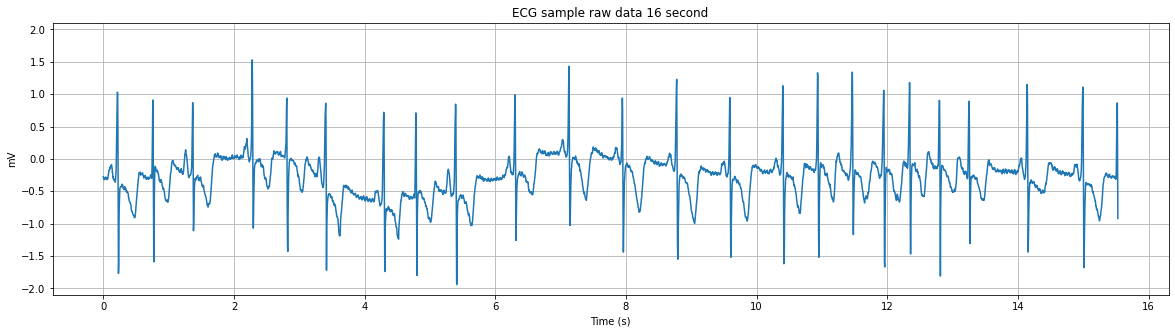

In [16]:
plot_signal(df_04015.between_time('09:00:00','09:00:16'), fs, "ECG sample raw data 16 second")

- Split Normal (N) and AFIB data

In [12]:
label_idx

[['09:00:00.120', 'N'],
 ['09:06:50.336', 'AFIB'],
 ['09:07:58.416', 'N'],
 ['09:08:07.092', 'AFIB'],
 ['09:08:08.776', 'N'],
 ['09:08:53.392', 'AFIB'],
 ['09:11:07.428', 'N']]

In [19]:
N_range = []
AFIB_range = []

for i in range(len(label_idx) - 1):
    tm_str = label_idx[i][0]
    next_tm_str = label_idx[i + 1][0]
    tm = pd.to_datetime(tm_str)
    next_tm = pd.to_datetime(next_tm_str)
    
    if label_idx[i][1] == 'N' :
        N_range.append([tm, next_tm])
    else :
        AFIB_range.append([tm, next_tm])

In [20]:
N = []
for nr in N_range :
    result = df_04015.between_time(nr[0].time(), nr[1].time())
    N.append(result)

In [21]:
AFIB = []
for ar in AFIB_range :
    result = df_04015.between_time(ar[0].time(), ar[1].time())
    AFIB.append(result)

- split each N & AFIB dataframe to 16s sequence and apply Baseline Removal 

In [22]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [23]:
def plot_16s_sample(data, label="Plot 16 s sample"):
    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('mV')
    plt.grid(True)
    plt.show()

In [24]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [25]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [26]:
time_interval_N = []
for N_item in N:
    intr = [time_result for time_result in perdelta(N_item.index[0], N_item.index[-1], timedelta(seconds=16))]
    time_interval_N.append(intr)

In [27]:
time_interval_AFIB = []
for AFIB_item in AFIB:
    intr = [time_result for time_result in perdelta(AFIB_item.index[0], AFIB_item.index[-1], timedelta(seconds=16))]
    time_interval_AFIB.append(intr)

In [28]:
ECG_ALS = []
ECG_ALS_label = []

for time_interval in time_interval_N :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_04015.between_time(time_intv[0].time(), time_intv[1].time())
        X_val = X.values[:,0]
        ALS = X_val - baseline_als(X_val)
        ECG_ALS.append(np.array(ALS))
        ECG_ALS_label.append('N')
        
for time_interval in time_interval_AFIB :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_04015.between_time(time_intv[0].time(), time_intv[1].time())
        X_val = X.values[:,0]
        ALS = X_val - baseline_als(X_val)
        ECG_ALS.append(np.array(ALS))
        ECG_ALS_label.append('AF')

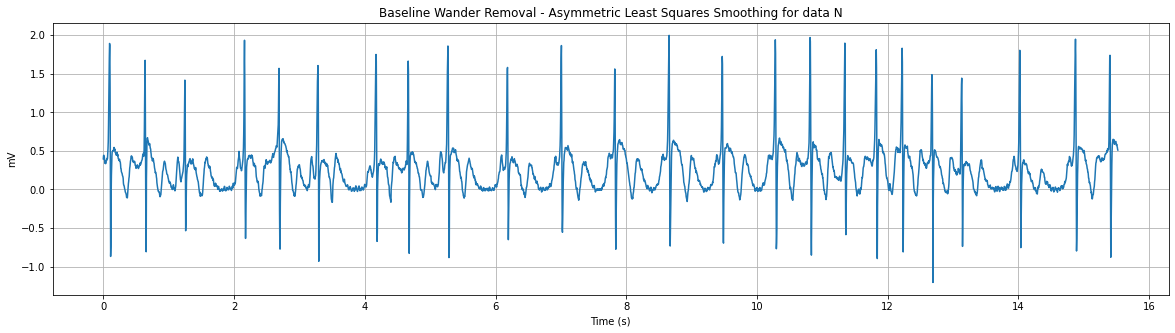

In [32]:
idx = 0
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

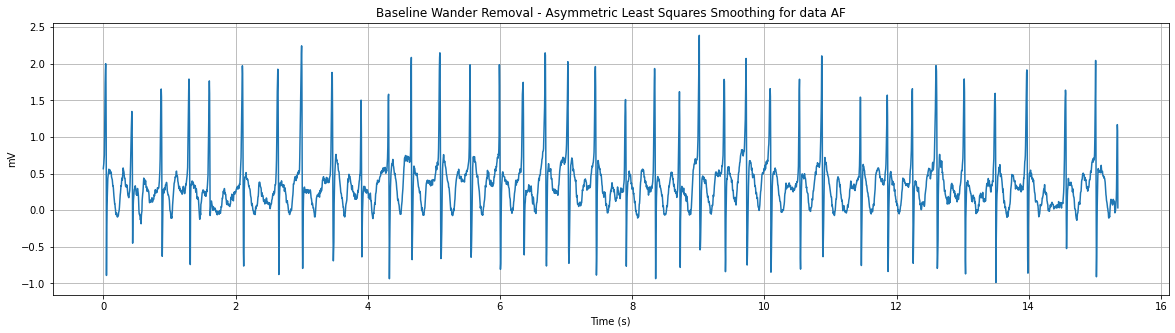

In [33]:
idx = -1
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

- QRS Detection

In [50]:
from ecgdetectors import Detectors

detectors = Detectors(fs)

In [52]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('mV')
    plt.grid(True)
    plt.show()

- Test R peak detector - Christov

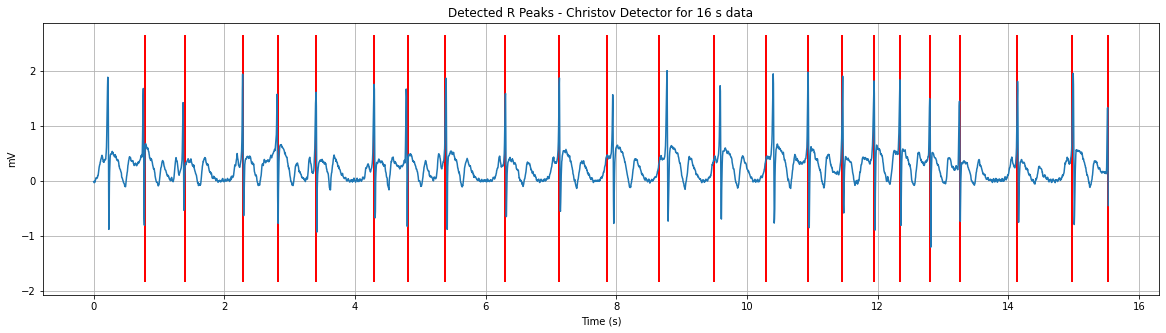

In [56]:
data = np.array(ECG_ALS[0])

r_peaks = detectors.christov_detector(data)

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks - Christov Detector for 16 s data")

- Split each 16s to 1.2 x R-R sequence
- Padding the sequence with zero for length 300 point

In [79]:
ECG_split = []
for data in ECG_ALS :
    data = np.array(data)
    r_peaks = detectors.christov_detector(data)
    RRs = np.diff(r_peaks)
    RRs_med = np.median(RRs)
    for rp in r_peaks :
        split = data[rp : rp + int(RRs_med * 1.2)] 
        pad = np.zeros(300)
        pad[0:len(split)] = split
        ECG_split.append(pad)

In [88]:
def plot_1_sample(data, fs):
    times = np.arange(data.shape[0]) / fs * 1000 

    plt.plot(times, data)
    plt.title("Plot 1 Sample (%dHz)" % fs)
    plt.xlabel("Time (ms)")
    plt.ylabel("mV")
    plt.grid(True)
    plt.show()

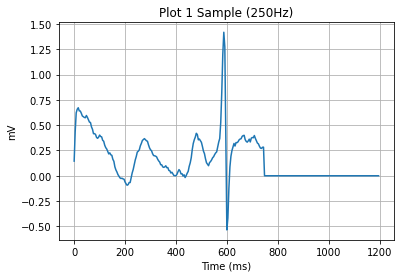

In [89]:
plot_1_sample(ECG_split[0], fs)

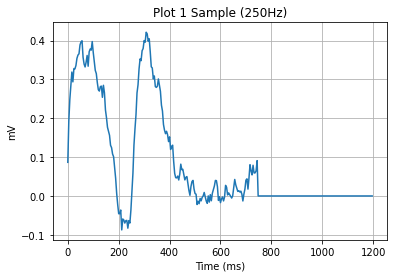

In [93]:
plot_1_sample(ECG_split[1], fs)

In [90]:
label_idx

[['09:00:00.120', 'N'],
 ['09:06:50.336', 'AFIB'],
 ['09:07:58.416', 'N'],
 ['09:08:07.092', 'AFIB'],
 ['09:08:08.776', 'N'],
 ['09:08:53.392', 'AFIB'],
 ['09:11:07.428', 'N']]

In [92]:
df_04015.index[0], pd.to_datetime(label_idx[-1][0])

(Timestamp('2020-12-03 09:00:00'), Timestamp('2020-12-03 09:11:07.428000'))